In [14]:
import torch
import os
import copy
from itertools import product
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from pytorch_tabnet.tab_model import TabNetRegressor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')

if not os.path.exists('results'):
    os.mkdir('results')

if not os.path.exists('results/pca'):
    os.mkdir('results/pca')

if not os.path.exists('results/no_pca'):
    os.mkdir('results/no_pca')

# TabNet: Attentive Interpretable Tabular Learning

In [15]:
# Paper: https://arxiv.org/pdf/1908.07442.pdf

is_pca = True

if is_pca:
    path = 'runs/tabnet/tab_pca/'
    results_path = 'results/pca/'
else:
    path = 'runs/tabnet/tab_no_pca/'
    results_path = 'results/no_pca/'

In [16]:
seed = 42
np.random.seed(seed)

df = pd.read_csv('dataset.csv')
display(df.head())
print(f'Number of samples: {df.shape[0]}')

,rating_mean,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,3.893708,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,...,0,0,0,0,0,0,0,0,0,0
1,3.251527,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,...,0,0,0,0,0,0,0,0,0,0
2,3.142028,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,...,0,0,0,0,0,1,0,0,0,0
3,2.853547,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,...,0,0,0,0,0,1,0,0,0,0
4,3.058434,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,...,0,0,0,0,0,0,0,0,0,0


Number of samples: 13798


In [17]:
# PyTorch Device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print("Using {} device".format(device))

Using cuda device


### Data Preprocessing

In [18]:
X = df.drop('rating_mean', axis=1)
y = df['rating_mean']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)

X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [19]:
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
print('Number of training samples:', X_train.shape[0])
print('Number of validation samples:', X_val.shape[0])
print('Number of test samples:', X_test.shape[0])

Number of training samples: 9934
Number of validation samples: 1104
Number of test samples: 2760


In [20]:
if is_pca:
    print("Applying PCA...")
    pca = PCA(n_components=0.95)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test)
    print(f'Number of features after PCA: {X_train.shape[1]}')
else:
    print("PCA is not applied")

Applying PCA...
Number of features after PCA: 543


# Tab Net Architecture

In [21]:
# Hyperparameters
num_epochs = 200
batch_size = [256]
v_batch_size = [128]  # deve essere minore di batch_size

# Number of consecutive epochs without improvement before performing early stopping.
patience = 10
# Coefficient for feature reusage in the masks. A value close to 1 will make mask selection least correlated between layers. Values range from 1.0 to 2.0.
gamma = [1.3, 1.2]
# Dimension of the transformation layer
n_d = [16, 32, 64]
# Dimension of the attentional layer
n_a = [16, 32, 64]
# Number of steps in the architecture (usually between 3 and 10)
n_steps = [3, 5, 7]
# Number of shared GLU layer in each GLU block (Default 2)
n_shared = 2
# Number of independent GLU layer in each GLU block (Default 2)
n_independent = 2

hyperparams = product(batch_size, v_batch_size, gamma, n_d, n_a, n_steps)
print(f'Number of combinations: {len(list(hyperparams))}')


Number of combinations: 54


In [22]:
# Training the model

best_model = None
best_mse = np.inf
best_config = None

i = 0

for batch_size, v_batch_size, gamma, n_d, n_a, n_steps in product(batch_size, v_batch_size, gamma, n_d, n_a, n_steps):
    i += 1

    # Tensorboard
    dir_name = f'batch_size={batch_size}_v_batch_size={v_batch_size}_gamma={gamma}_n_d={n_d}_n_a={n_a}_n_steps={n_steps}'

    if os.path.exists(path + dir_name):
        print("Combination already trained, skipping...")
        continue

    writer = SummaryWriter(path + dir_name)

    print(f'Combination {i}')
    print(
        f'batch_size={batch_size}, v_batch_size={v_batch_size}, gamma={gamma}, n_d={n_d}, n_a={n_a}, n_steps={n_steps}')

    model = TabNetRegressor(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        n_shared=n_shared,
        n_independent=n_independent,
        optimizer_fn=torch.optim.Adam,
        seed=seed,
    )

    model.fit(
        X_train=X_train,
        y_train=y_train,
        eval_set=[(X_val, y_val)],
        eval_name=["val"],
        eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
        max_epochs=num_epochs,
        patience=patience,
        batch_size=batch_size,
        virtual_batch_size=v_batch_size,
        num_workers=0,
        drop_last=False,
        loss_fn=torch.nn.functional.mse_loss,
    )

    # Evaluation
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'MSE: {mse}')
    print(f'R2 Score: {r2}')

    config = {
        'batch_size': batch_size,
        'v_batch_size': v_batch_size,
        'gamma': gamma,
        'n_d': n_d,
        'n_a': n_a,
        'n_steps': n_steps,
    }

    writer.add_hparams(config, {'hparam/mse': mse, 'hparam/r2': r2})
    writer.flush()

    if mse < best_mse:
        best_mse = mse
        best_model = copy.deepcopy(model)
        best_config = config
        print("Best model updated")

    writer.close()


Combination 1
batch_size=256, v_batch_size=128, gamma=1.3, n_d=16, n_a=16, n_steps=3
epoch 0  | loss: 3.28589 | val_rmsle: 0.13868 | val_mae: 1.294   | val_rmse: 1.37334 | val_mse: 1.88606 |  0:00:01s
epoch 1  | loss: 0.29951 | val_rmsle: 0.02732 | val_mae: 0.59376 | val_rmse: 0.68268 | val_mse: 0.46605 |  0:00:02s
epoch 2  | loss: 0.23041 | val_rmsle: 0.01181 | val_mae: 0.35933 | val_rmse: 0.44129 | val_mse: 0.19474 |  0:00:03s
epoch 3  | loss: 0.1531  | val_rmsle: 0.00667 | val_mae: 0.2538  | val_rmse: 0.32566 | val_mse: 0.10606 |  0:00:04s
epoch 4  | loss: 0.13564 | val_rmsle: 0.00694 | val_mae: 0.25734 | val_rmse: 0.33189 | val_mse: 0.11015 |  0:00:05s
epoch 5  | loss: 0.12621 | val_rmsle: 0.00643 | val_mae: 0.25503 | val_rmse: 0.32002 | val_mse: 0.10241 |  0:00:06s
epoch 6  | loss: 0.12323 | val_rmsle: 0.00691 | val_mae: 0.25903 | val_rmse: 0.33184 | val_mse: 0.11012 |  0:00:07s
epoch 7  | loss: 0.11731 | val_rmsle: 0.00625 | val_mae: 0.24166 | val_rmse: 0.31315 | val_mse: 0.09806

In [27]:
# Saving the best model
if is_pca:
    saving_path = 'tabnet_model_pca'
else:
    saving_path = 'tabnet_model_no_pca'

saved_filepath = best_model.save_model(saving_path)

loaded_model = TabNetRegressor()
loaded_model.load_model(saved_filepath)

Successfully saved model at tabnet_model_pca.zip


In [28]:
# Evaluation
y_pred = loaded_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R2: {r2}')

open(results_path + 'tabnet', 'w').write(f'{best_config} MSE: {mse} R2: {r2}\n')

MSE: 0.0065027656965687235
R2: 0.9711705116657816


141

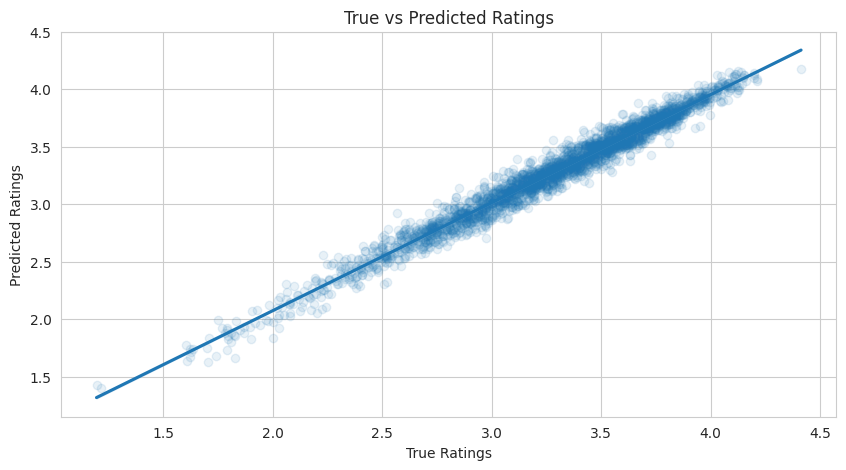

In [25]:
# Plotting
plt.figure(figsize=(10, 5))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.1})
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs Predicted Ratings')
plt.show()

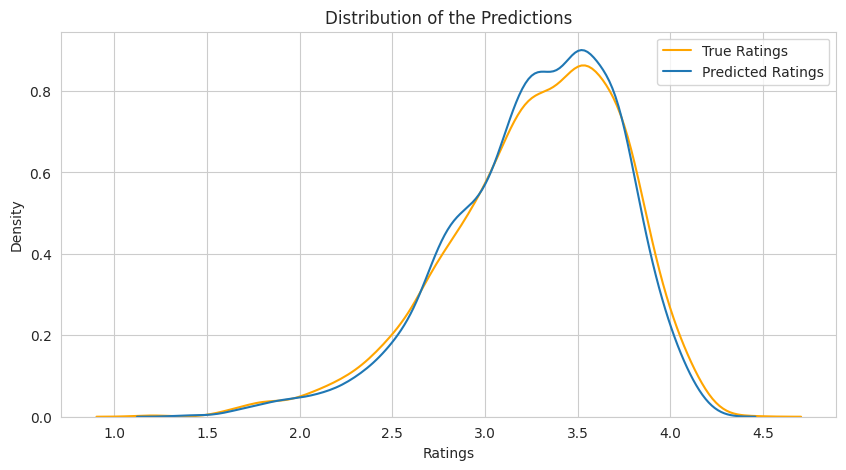

In [26]:
# Distribution of the predictions
plt.figure(figsize=(10, 5))
sns.kdeplot(y_test, color='orange')
sns.kdeplot(y_pred, color='b')
plt.xlabel('Ratings')
plt.ylabel('Density')
plt.title('Distribution of the Predictions')
plt.legend(['True Ratings', 'Predicted Ratings'])
plt.show()